In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import json
import matplotlib.colors as colors

sys.path.append(os.path.join('..'))

from counting_boats.boat_utils.image_cutting_support import latlong2coord, coord2latlong



In [68]:

DETECTION_CSV   = 'C:/ML_Software/All_Results/boat_detections.csv'
COVERAGE_CSV    = 'C:/ML_Software/All_Results/coverage.csv'
ORDERS_CSV      = 'C:/ML_Software/All_Results/orders.csv'
UDM_DIR         = 'D:/Results/UDM'
GRID_SIZE       = 500 # Meters

# Plots

## Density Plots
- Count/Time seen for each grid cell
    - Aggregate years
    - Aggregate months
    - Aggregate Days of weeks (or weekend/weekday)

- Moving vs Static Boats density (3D spatial plots)
    - Aggregate years
    - Aggregate months
    - Aggregate Days of weeks (or weekend/weekday)

## Numerical Plots
- Data availability over time
    - % of AOI per day over time
    - Raw counts over time (limited to >90% AOI coverage)
    - Any imputations



In [45]:
# Detections are in the form of latitude, longitude, and date for each detection.
# We can get the extent of the detections by finding the min and max of lat/lons.
# Need to convert lat long into an EPSG projection in meters.
# Then use the extent to define the grid.
# Assign each detection to a grid cell (gridx, gridy) for further analysis

all_detections = pd.read_csv(DETECTION_CSV)
print("We have {} detections".format(len(all_detections)))
all_detections["date"] = pd.to_datetime(all_detections["date"], dayfirst=True)

# convert lat long to meters (x, y)
if 'epsg32756_x' not in all_detections.columns:
    all_detections['epsg32756_x'], all_detections['epsg32756_y'] = latlong2coord(all_detections['longitude'], all_detections['latitude'])
    # save the new columns
    print("Saving new columns")
    all_detections.to_csv(DETECTION_CSV, index=False)

print("Converted lat long to meters")
all_detections.head()
print("We have {} detections".format(len(all_detections)))


We have 1049407 detections
Converted lat long to meters
We have 1049407 detections


C:\Users\turner30\AppData\Local\Temp\ipykernel_6596\3598742281.py:9: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  all_detections["date"] = pd.to_datetime(all_detections["date"], dayfirst=True)


In [69]:


# Extent should be the minimum and maximum possible extent, use the geojson for this
geojson_file = "../data/polygons/moreton.geojson"
min_lat, min_lon, max_lat, max_lon = 9999, 9999, -9999, -9999 
with open(geojson_file, 'r') as f:
    geojson = json.load(f)
    for poly in geojson['coordinates'][0]:
        for coord in poly:
            if coord[0] < min_lon:
                min_lon = coord[0]
            if coord[0] > max_lon:
                max_lon = coord[0]
            if coord[1] < min_lat:
                min_lat = coord[1]
            if coord[1] > max_lat:
                max_lat = coord[1]

# convert lat long to meters (x, y)
grid_minx, grid_miny = latlong2coord(min_lon, min_lat)
grid_maxx, grid_maxy = latlong2coord(max_lon, max_lat)

# meters go left and up, so minx, miny is the bottom left corner
MINLON, MINLAT = coord2latlong(grid_minx, grid_miny)
MAXLON, MAXLAT = coord2latlong(grid_maxx, grid_maxy)

# round to nearest grid size
# floor the minimums
grid_minx = int(grid_minx // GRID_SIZE) * GRID_SIZE
grid_miny = int(grid_miny // GRID_SIZE) * GRID_SIZE

# ceil the maximums
grid_maxx = int(grid_maxx // GRID_SIZE) * GRID_SIZE + GRID_SIZE
grid_maxy = int(grid_maxy // GRID_SIZE) * GRID_SIZE + GRID_SIZE

# define the grid
grid_rows = int((grid_maxy - grid_miny) // GRID_SIZE) + 1
grid_cols = int((grid_maxx - grid_minx) // GRID_SIZE) + 1

def point_to_grid(x, y):
    """ Given a point in meters (32756), 
        return the grid cell it belongs to in image coordinates (origin top left)
    """
    gridx = int((x - grid_minx) // GRID_SIZE)
    gridy = grid_rows - int((y - grid_miny) // GRID_SIZE) - 1
    return gridx, gridy

assert point_to_grid(grid_minx, grid_maxy) == (0, 0)
assert point_to_grid(grid_maxx, grid_miny) == (grid_cols - 1, grid_rows - 1)

point_to_grid = np.vectorize(point_to_grid)
# assign each detection to a grid cell
all_detections['gridx'], all_detections['gridy'] = point_to_grid(all_detections['epsg32756_x'], all_detections['epsg32756_y'])
# filter out any that are outside the grid
all_detections = all_detections[(all_detections['gridx'] >= 0) & (all_detections['gridx'] < grid_cols) & (all_detections['gridy'] >= 0) & (all_detections['gridy'] < grid_rows)]

all_detections.head()


date  class                images   latitude   longitude  confidence  \
0 2016-07-19      1  20160719_moreton.tif -27.538218  153.297872    0.694590   
1 2016-07-19      1  20160719_moreton.tif -27.167945  153.347242    0.793097   
2 2016-08-04      1  20160804_moreton.tif -27.067171  153.137747    0.705099   
3 2016-08-04      1  20160804_moreton.tif -27.427190  153.248675    0.775060   
4 2016-08-04      1  20160804_moreton.tif -27.471375  153.355871    0.615021   

           w          h      aoi  epsg32756_x  epsg32756_y  gridx  gridy  year  
0  31.499998  33.166675  moreton     529411.5    6953914.5     57    164  2016  
1  42.062511  47.999926  moreton     534400.5    6994915.5     67     82  2016  
2  23.500006  22.666682  moreton     513658.5    7006117.5     26     59  2016  
3  30.928563  26.142854  moreton     524578.5    6966223.5     48    139  2016  
4  17.000006  19.000010  moreton     535159.5    6961303.5     69    149  2016

## Count/Time seen for each grid cell

In [65]:
# Now, normalise the counts by the coverage. E.g if a grid cell has 2 detections and 3 images, the normalised count is 2/3
# if the grid cell has 0 images, the count is NaN. If the grid cell has 0 detections but more than 1 image, the count is 0
def normalise_counts(heatmaps, grouped_counts):
    normalised_counts = {}

    # Preprocess grouped_counts to get counts per grid cell
    grouped_counts = grouped_counts.apply(
        lambda x: x.groupby(['gridx', 'gridy']).size().reset_index(name='counts')
    )

    for key in heatmaps:
        # Initialize coverage and counts arrays
        coverage_array = np.full((grid_rows, grid_cols), np.nan)
        counts_array = np.zeros((grid_rows, grid_cols))

        # Build coverage_array from heatmaps[key]
        if heatmaps[key]:
            grid_cells = np.array(list(heatmaps[key].keys()))
            gridx_array = grid_cells[:, 0].astype(int)
            gridy_array = grid_cells[:, 1].astype(int)
            coverages = np.array(list(heatmaps[key].values()))
            coverage_array[gridy_array, gridx_array] = coverages

        # Build counts_array from grouped_counts
        key_data = grouped_counts.loc[key] if key in grouped_counts.index else pd.DataFrame()
        if not key_data.empty:
            gridx_counts = key_data['gridx'].values.astype(int)
            gridy_counts = key_data['gridy'].values.astype(int)
            counts = key_data['counts'].values
            counts_array[gridy_counts, gridx_counts] = counts

        # Compute normalized counts using vectorized operations
        with np.errstate(divide='ignore', invalid='ignore'):
            normalised_counts_array = counts_array / coverage_array

        # Set cells with zero coverage to NaN
        normalised_counts_array[coverage_array == 0] = np.nan

        normalised_counts[key] = normalised_counts_array

    return normalised_counts


In [72]:
from mpl_toolkits.basemap import Basemap
from counting_boats.boat_utils.image_cutting_support import coord2latlong
from tqdm import tqdm

def plot_counts_on_map(counts_dict, geojson_file):
    num_plots = len(counts_dict)
    cols = 3
    rows = int(np.ceil(num_plots / cols))
    fig, axs = plt.subplots(rows, cols, figsize=(20, 20))
    axs = axs.flatten()
    for id, (key, counts) in enumerate(counts_dict.items()):
        print(f'Plotting {key}')
        ax = axs[id]
        ax.set_title(f'Normalised counts of boats detected in {key}')
        max_count = np.nanmax(counts)
        m = Basemap(llcrnrlon=MINLON, llcrnrlat=MINLAT, urcrnrlon=MAXLON, urcrnrlat=MAXLAT, epsg=4326, ax=ax)

        m.arcgisimage(service='World_Imagery', verbose=True)

        m.imshow(counts, cmap='hot', interpolation='nearest', alpha=0.5, vmin=0, vmax=max_count, origin="upper")

        # draw the polygon outline from geojson
        with open(geojson_file, 'r') as f:
            geojson = json.load(f)
            for poly in geojson['coordinates'][0]:
                lon, lat = zip(*poly)
                x, y = m(lon, lat)
                m.plot(x, y, marker=None, color='w', linewidth=1)
        
        print(f"Total detections in {key}: {np.nansum(counts)}")

    # hide the last axes
    for i in range(id + 1, len(axs)):
        fig.delaxes(axs[i])
    
    plt.tight_layout()
    plt.show()
    

In [102]:
# just the coverage on a basemap

def plot_coverage(heatmaps, totals):
    '''
    Plot the coverage on a basemap
    totals should have the same keys as heatmaps and is used for normalisation
    '''
    num_plots = len(heatmaps)
    cols = 5
    rows = int(np.ceil(num_plots / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
    axes = axes.flatten()

    for id, (key, heatmap) in enumerate(heatmaps.items()):
        ax = axes[id]
        ax.set_title(f'Coverage for {key}')
        m = Basemap(llcrnrlon=MINLON, llcrnrlat=MINLAT, urcrnrlon=MAXLON, urcrnrlat=MAXLAT, epsg=4326, ax=ax)

        m.arcgisimage(service='World_Imagery', verbose=True)

        grid = np.zeros((grid_rows, grid_cols))
        for (x, y), coverage in heatmap.items():
            grid[y][x] = coverage
        
        gridnorm = grid / totals[key]

        grid_valid = np.ma.masked_where(gridnorm == 0, gridnorm)
        # Define the discrete bins you want
        levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

        # Create a colormap with discrete colors
        cmap = plt.get_cmap('hot', len(levels) - 1)  # Using 'hot' colormap with discrete intervals

        # Create a normalizer that maps data values to colormap bins
        norm = colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)

        # Plot the grid with the discrete colormap and normalization
        im = m.imshow(
            grid_valid,
            cmap=cmap,
            norm=norm,
            interpolation='nearest',
            alpha=0.5,
            origin='upper',
        )

        # Create a colorbar with discrete intervals
        cbar = m.colorbar(
            im,
            location='bottom',
            label='Coverage',
            boundaries=levels,
            ticks=levels,
            spacing='proportional',
        )

        # Optionally, adjust tick labels if needed
        cbar.ax.set_xticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])

        # draw the polygon outline from geojson
        with open(geojson_file, 'r') as f:
            geojson = json.load(f)
            for poly in geojson['coordinates'][0]:
                lon, lat = zip(*poly)
                x, y = m(lon, lat)
                m.plot(x, y, marker=None, color='w', linewidth=1)
    # hide the last axes
    for i in range(id + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


In [52]:
def plot_points_on_map(detections, geojson):
    """Plot all the lat/lon points on the map"""
    fig, ax = plt.subplots(figsize=(20, 20))
    m = Basemap(llcrnrlon=MINLON, llcrnrlat=MINLAT, urcrnrlon=MAXLON, urcrnrlat=MAXLAT, epsg=4326, ax=ax)

    m.arcgisimage(service='World_Imagery', verbose=True)

    x, y = m(detections['longitude'].values, detections['latitude'].values)
    # scatter with color as: blue for 0, red for 1
    m.scatter(x, y, c=detections['class'].values, cmap='coolwarm', alpha=0.5, s=0.5)
    # draw the polygon outline from geojson
    with open(geojson, 'r') as f:
        geojson = json.load(f)
        for poly in geojson['coordinates'][0]:
            lon, lat = zip(*poly)
            x, y = m(lon, lat)
            m.plot(x, y, marker=None, color='w', linewidth=1)
    plt.show()

# plot_points_on_map(all_detections, geojson_file)

dict_keys([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])
Normalising counts


C:\Users\turner30\AppData\Local\Temp\ipykernel_6596\3067743816.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_counts = grouped_counts.apply(


Plotting counts
Plotting Heatmaps
http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=153.01015278393564,-27.931705454737312,153.46015559548024,-26.804500593418485&bboxSR=4326&imageSR=4326&size=400,1001&dpi=96&format=png32&transparent=true&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=153.01015278393564,-27.931705454737312,153.46015559548024,-26.804500593418485&bboxSR=4326&imageSR=4326&size=400,1001&dpi=96&format=png32&transparent=true&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=153.01015278393564,-27.931705454737312,153.46015559548024,-26.804500593418485&bboxSR=4326&imageSR=4326&size=400,1001&dpi=96&format=png32&transparent=true&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=153.01015278393564,-27.931705454737312,153.46015559548024,-26.804500593418485&bboxSR=4326&imageSR=4326&size=400,1001&dpi=96&form

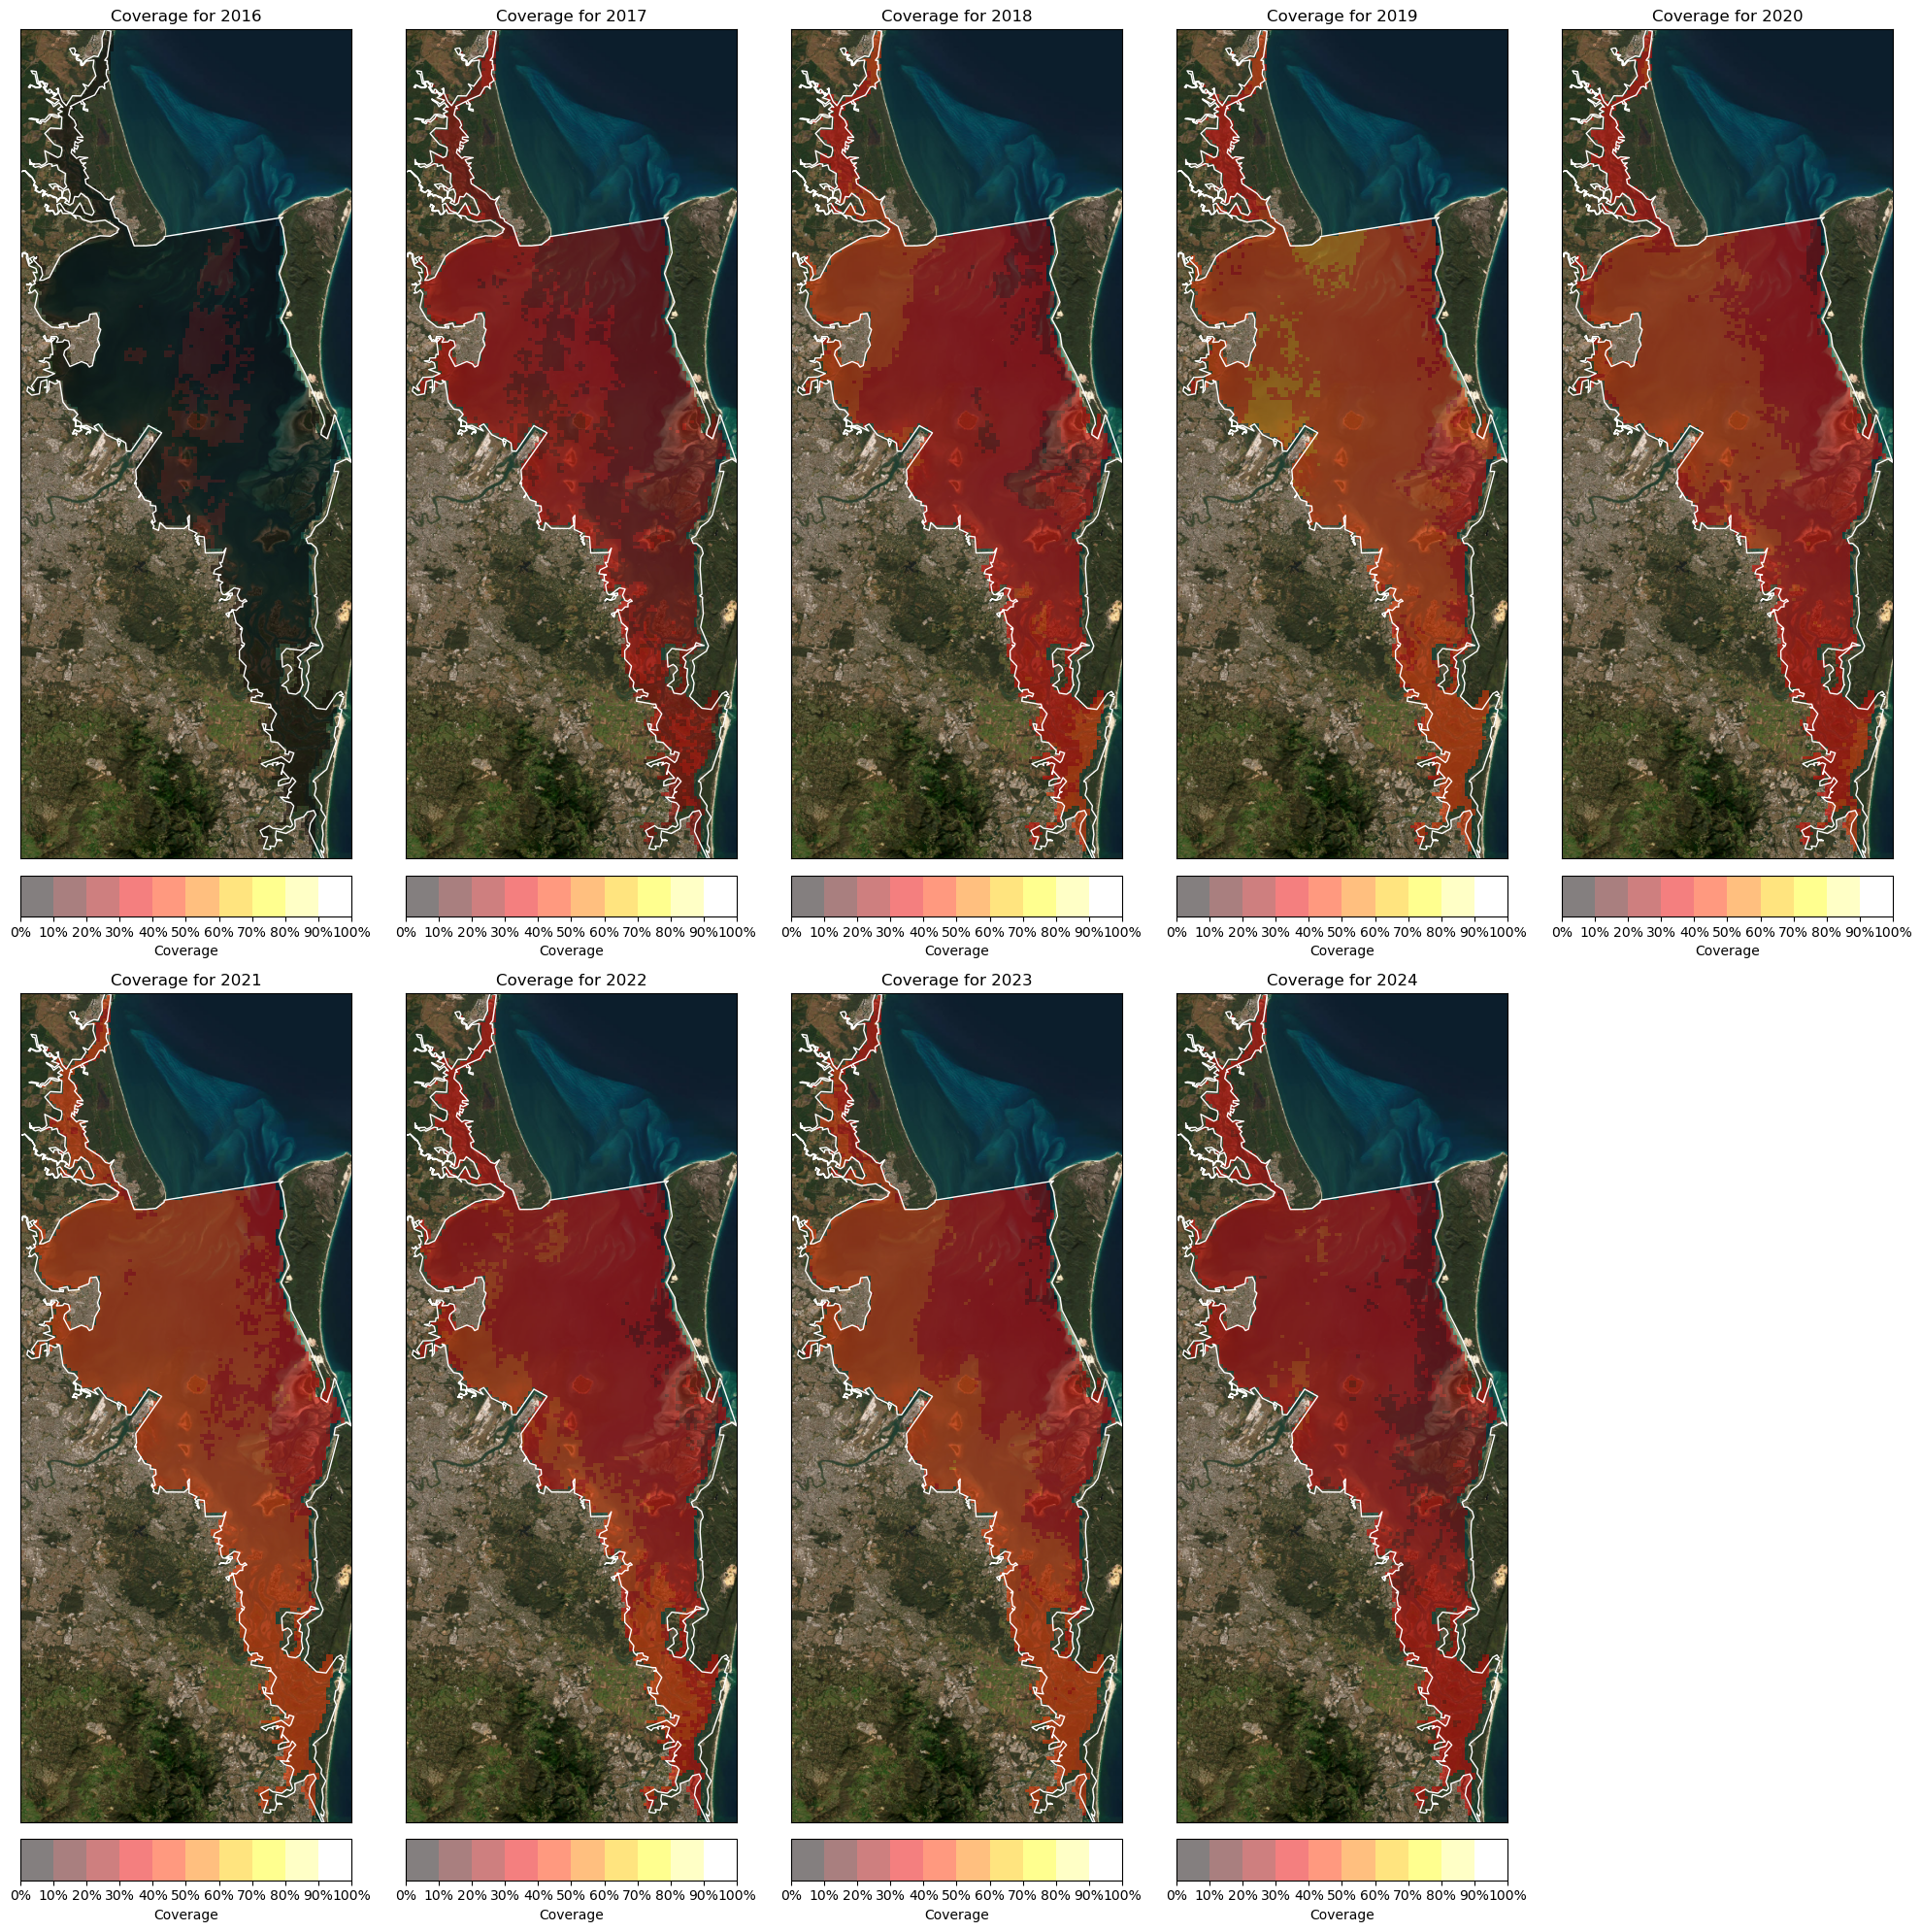

In [103]:

import pickle
# Group detections by year, and then count by grid cell
all_detections['year'] = all_detections['date'].dt.year
# all_detections = all_detections[all_detections['year'] <= 2017]
year_grouped = all_detections.groupby('year')
# only use 2016 and 2017

def key_function(x):
    return int(x.split('_')[1][:4])

heatmaps = {}

with open("heatmaps.csv", "r") as f:
    data = f.read()
    for line in data.split('\n'):
        if not line:
            continue
        # year,gridx,gridy,count
        year, gridx, gridy, count = line.split(',')
        if year == 'year':
            continue
        year = int(year)
        gridx = int(gridx)
        gridy = int(gridy)
        count = int(count)
        if year not in heatmaps:
            heatmaps[year] = {}
        heatmaps[year][(gridx, gridy)] = count
# sort the items    
heatmaps = dict(sorted(heatmaps.items()))
print(heatmaps.keys())

totals = {}
# in this case, want totals to be the number of days between the first and last detection
for key, group in year_grouped:
    totals[key] = (group['date'].max() - group['date'].min()).days + 1

print("Normalising counts")
normalised_counts = normalise_counts(heatmaps, year_grouped)
print("Plotting counts")
# plot_counts_on_map(normalised_counts, geojson_file)
print("Plotting Heatmaps")
plot_coverage(heatmaps, totals)
# plot_points_on_map(all_detections, geojson_file)




C:\Users\turner30\AppData\Local\Temp\ipykernel_14844\3595511202.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_counts = grouped_counts.apply(lambda x: x.groupby(['gridx', 'gridy']).size().reset_index(name='counts'))
C:\Users\turner30\AppData\Local\Temp\ipykernel_14844\956459339.py:15: RuntimeWarning: All-NaN slice encountered
  max_count = np.nanmax(counts)


http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=153.01015278393564,-27.93324883315528,153.61062063249398,-26.802223773769505&bboxSR=4326&imageSR=4326&size=400,753&dpi=96&format=png32&transparent=true&f=image
Total detections in 26: 0
http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=153.01015278393564,-27.93324883315528,153.61062063249398,-26.802223773769505&bboxSR=4326&imageSR=4326&size=400,753&dpi=96&format=png32&transparent=true&f=image
Total detections in 29: 0
http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=153.01015278393564,-27.93324883315528,153.61062063249398,-26.802223773769505&bboxSR=4326&imageSR=4326&size=400,753&dpi=96&format=png32&transparent=true&f=image
Total detections in 31: 0
http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=153.01015278393564,-27.93324883315528,153.61062063249398,-26.802223773769505&bboxSR=4326&i

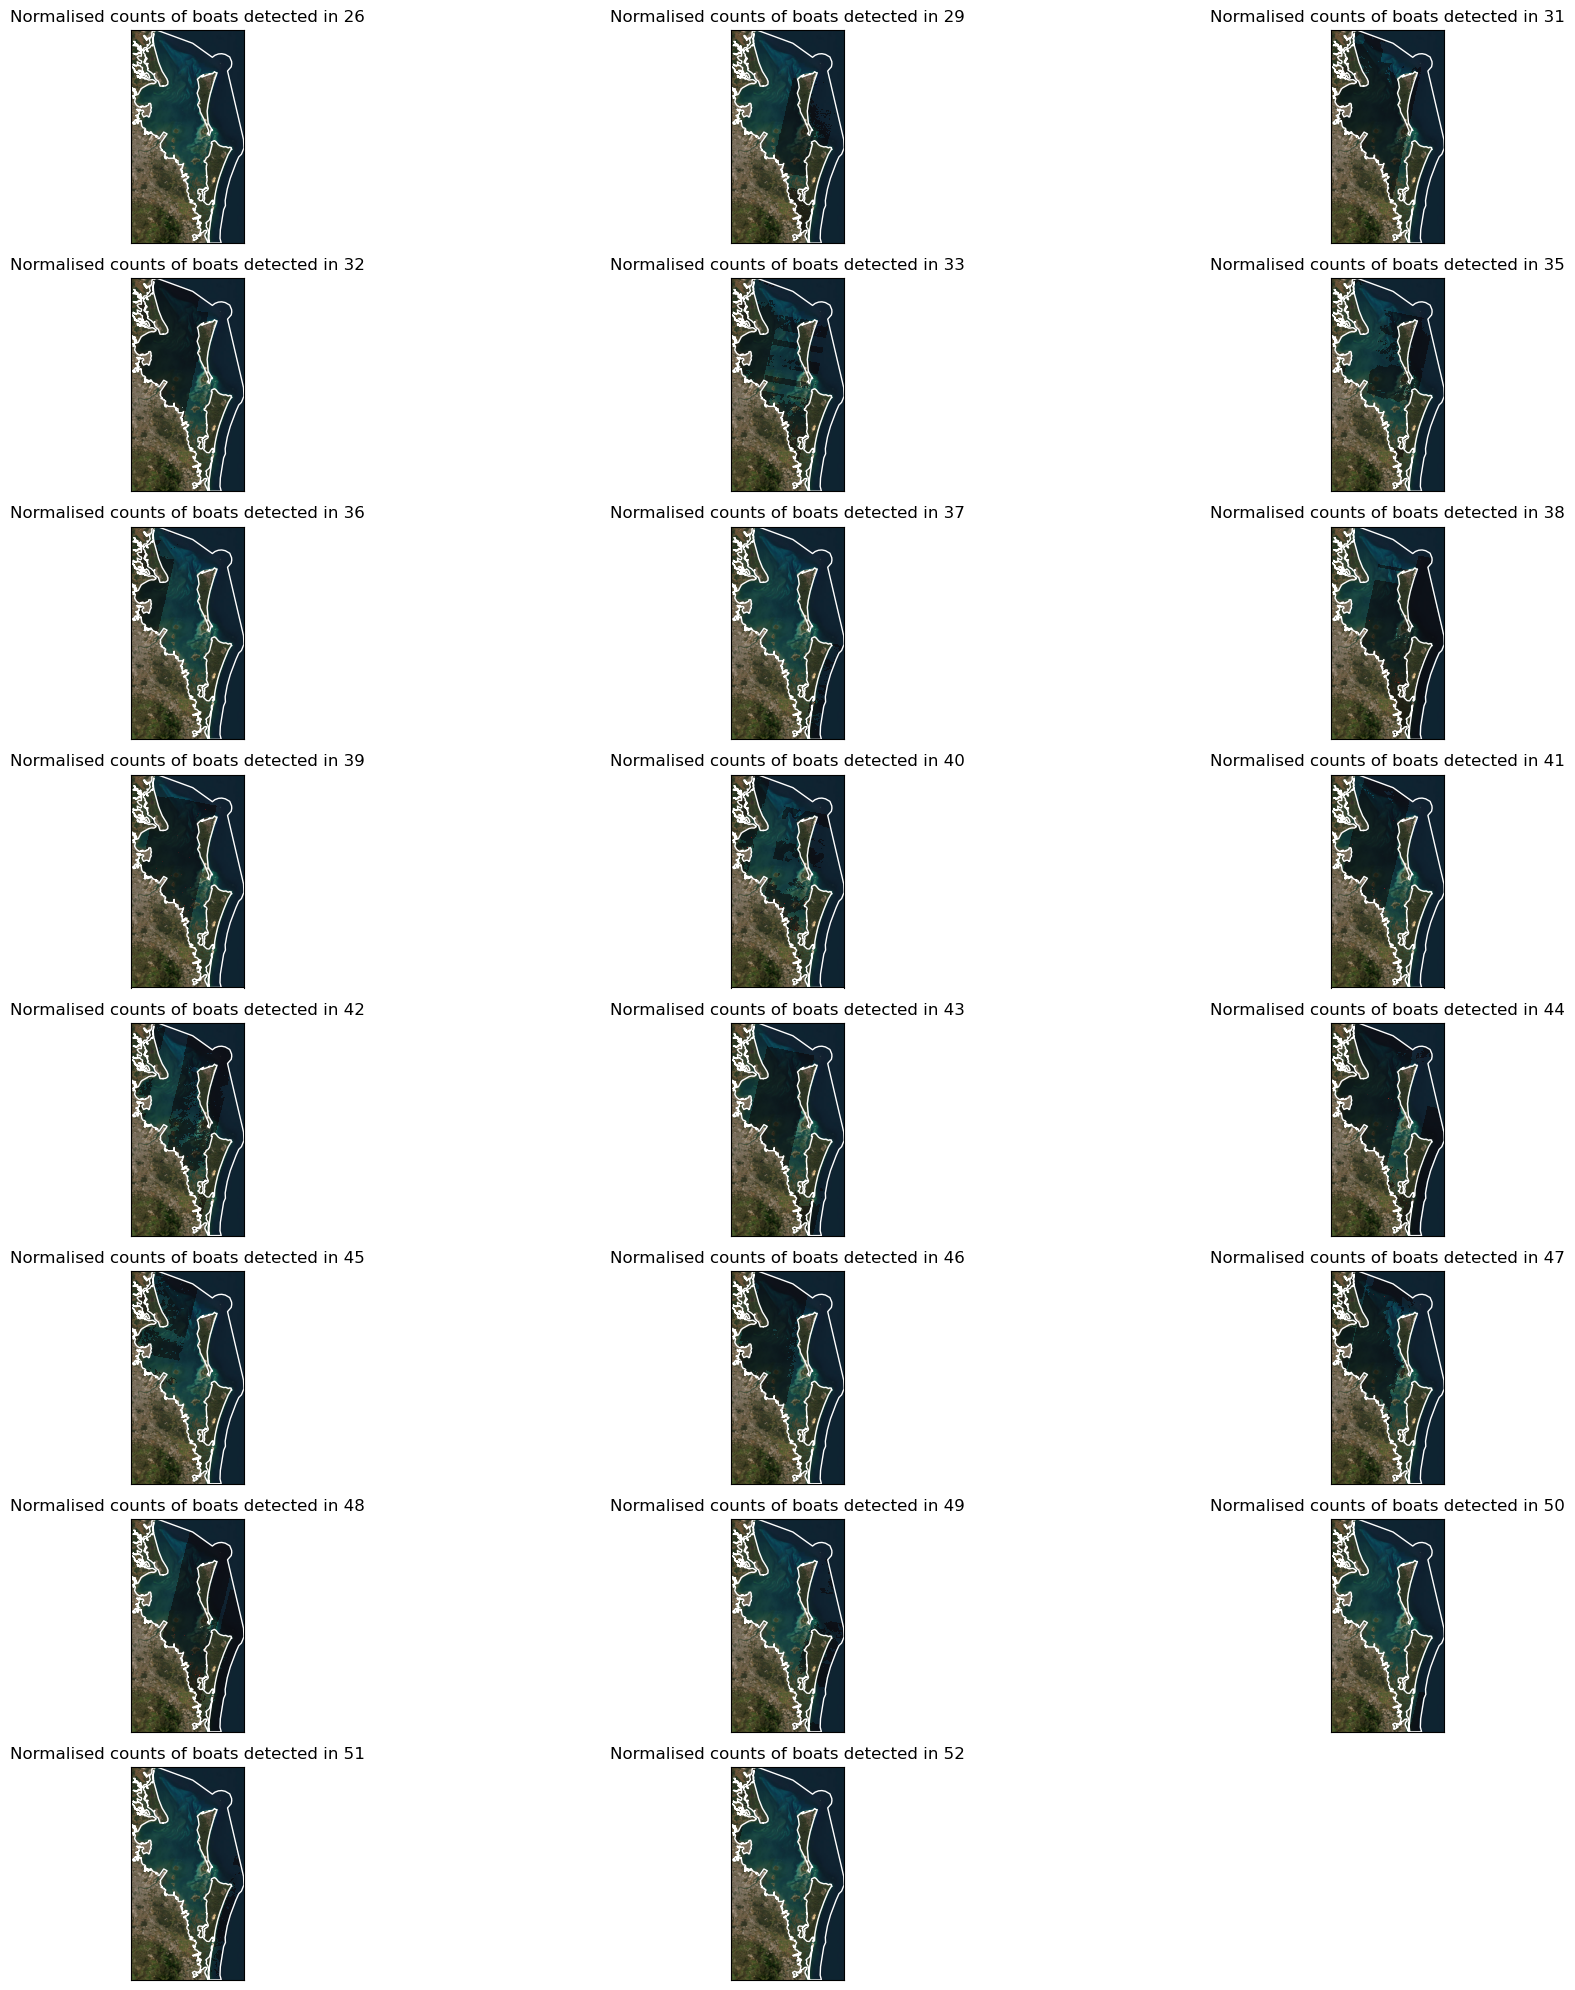

http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=153.01015278393564,-27.93324883315528,153.61062063249398,-26.802223773769505&bboxSR=4326&imageSR=4326&size=400,753&dpi=96&format=png32&transparent=true&f=image


C:\Users\turner30\AppData\Local\Temp\ipykernel_14844\2376373528.py:21: RuntimeWarning: invalid value encountered in divide
  grid = grid / np.nanmax(grid)


http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=153.01015278393564,-27.93324883315528,153.61062063249398,-26.802223773769505&bboxSR=4326&imageSR=4326&size=400,753&dpi=96&format=png32&transparent=true&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=153.01015278393564,-27.93324883315528,153.61062063249398,-26.802223773769505&bboxSR=4326&imageSR=4326&size=400,753&dpi=96&format=png32&transparent=true&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=153.01015278393564,-27.93324883315528,153.61062063249398,-26.802223773769505&bboxSR=4326&imageSR=4326&size=400,753&dpi=96&format=png32&transparent=true&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=153.01015278393564,-27.93324883315528,153.61062063249398,-26.802223773769505&bboxSR=4326&imageSR=4326&size=400,753&dpi=96&format=png32&transparent=true&f=image
http://s

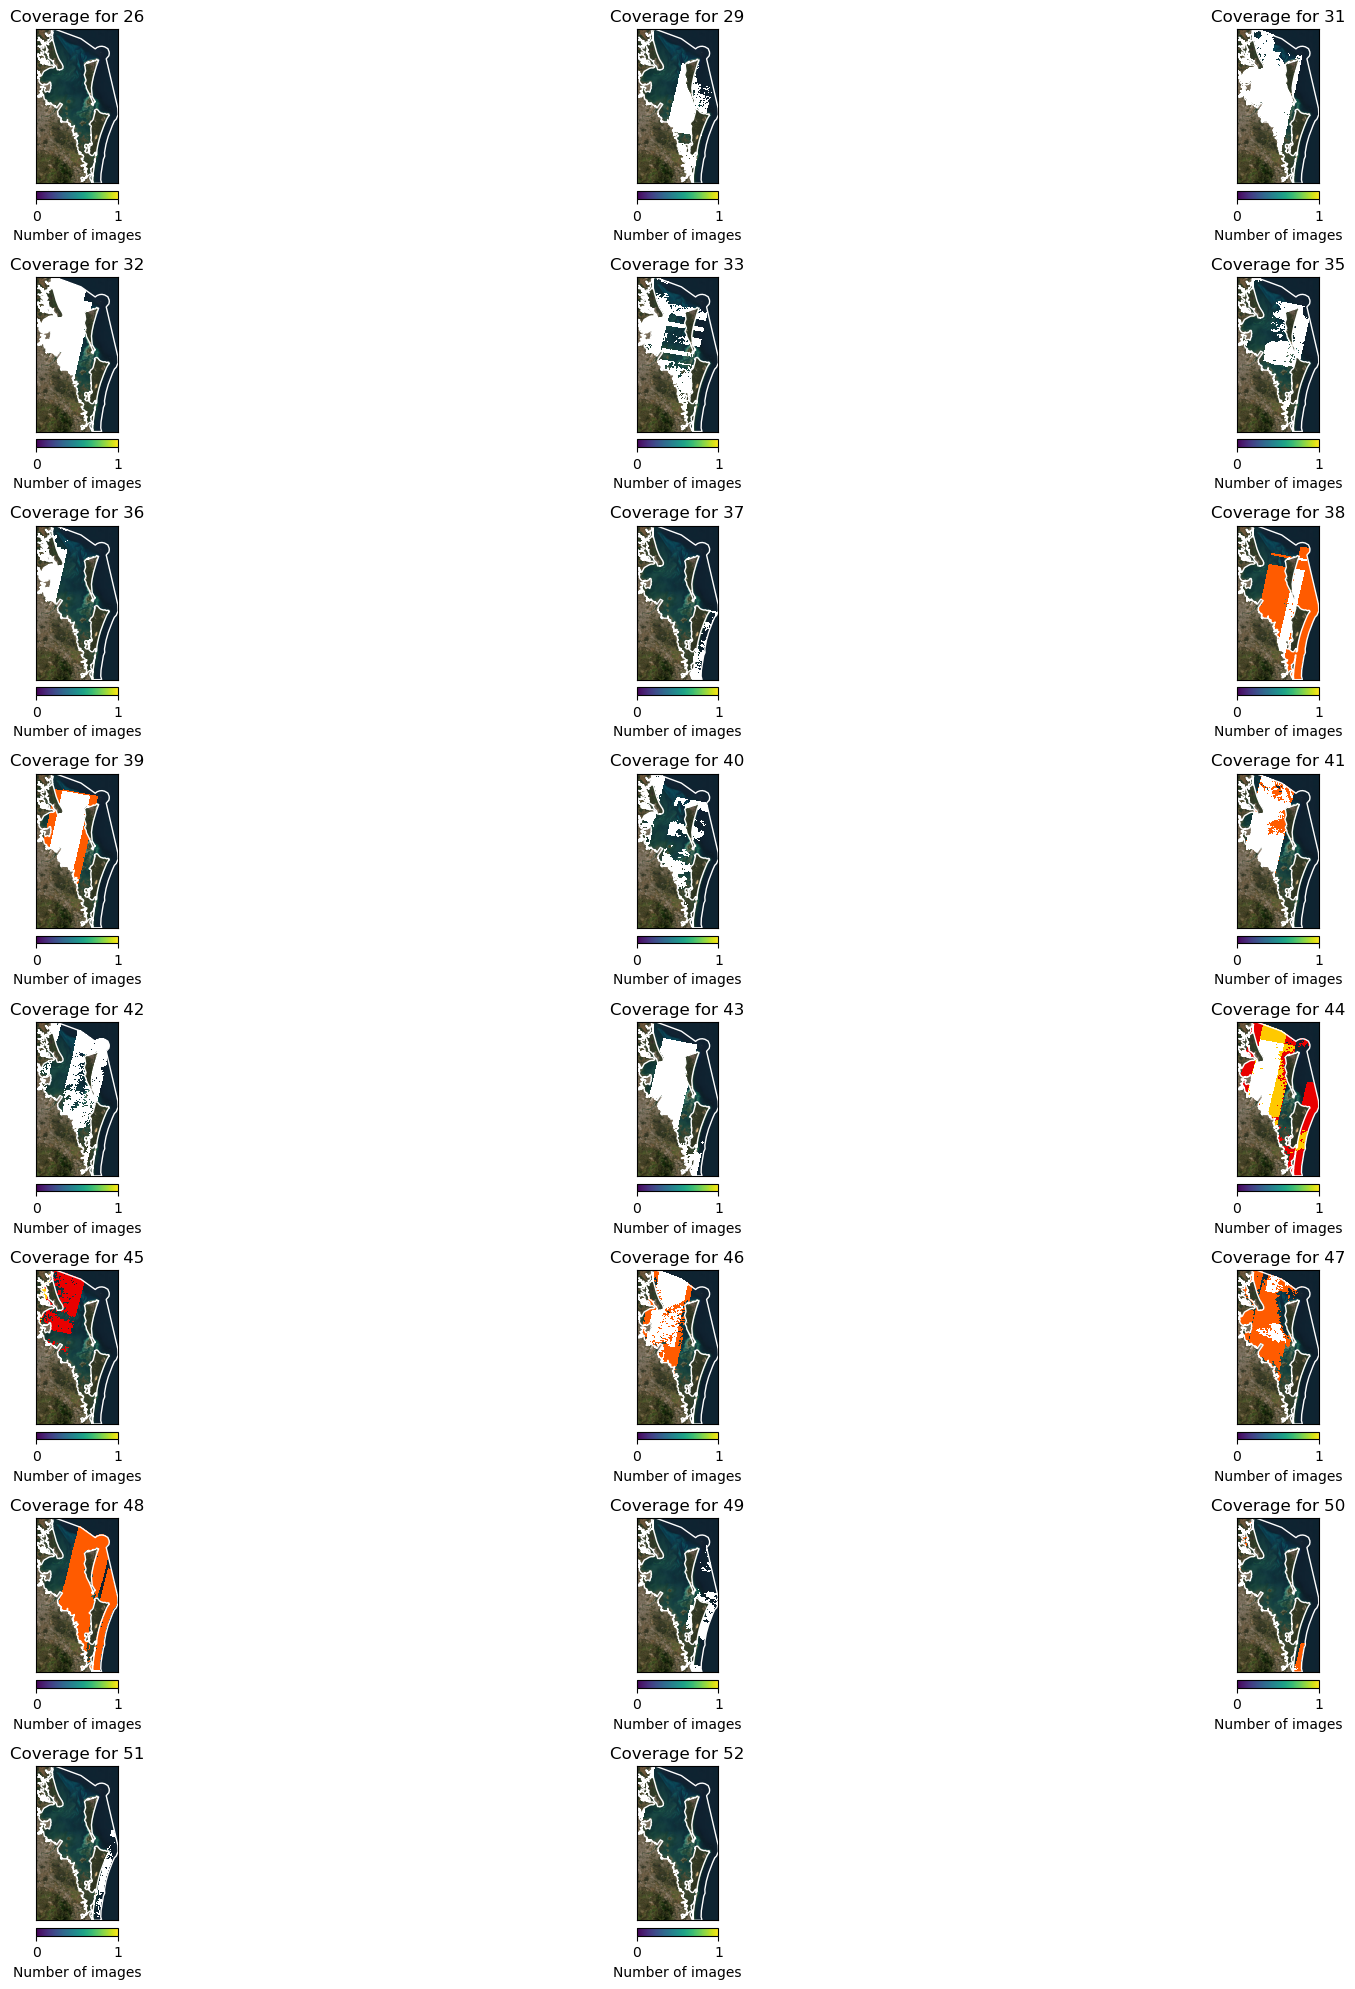

In [26]:
# same but for weekly data
all_detections['week'] = all_detections['date'].dt.isocalendar().week
week_grouped = all_detections.groupby('week')

date_to_week = lambda s: pd.to_datetime(f"{s[4:6]}/{s[6:8]}/{s[:4]}").isocalendar().week

normalised_counts = normalise_counts(heatmaps, week_grouped)
plot_counts_on_map(normalised_counts, geojson_file)
plot_coverage(heatmaps)



C:\Users\turner30\AppData\Local\Temp\ipykernel_14844\3595511202.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_counts = grouped_counts.apply(lambda x: x.groupby(['gridx', 'gridy']).size().reset_index(name='counts'))


http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=153.01015278393564,-27.93324883315528,153.61062063249398,-26.802223773769505&bboxSR=4326&imageSR=4326&size=400,753&dpi=96&format=png32&transparent=true&f=image
Total detections in Jul: 0
http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=153.01015278393564,-27.93324883315528,153.61062063249398,-26.802223773769505&bboxSR=4326&imageSR=4326&size=400,753&dpi=96&format=png32&transparent=true&f=image
Total detections in Aug: 0
http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=153.01015278393564,-27.93324883315528,153.61062063249398,-26.802223773769505&bboxSR=4326&imageSR=4326&size=400,753&dpi=96&format=png32&transparent=true&f=image
Total detections in Sep: 0
http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=153.01015278393564,-27.93324883315528,153.61062063249398,-26.802223773769505&bboxSR=432

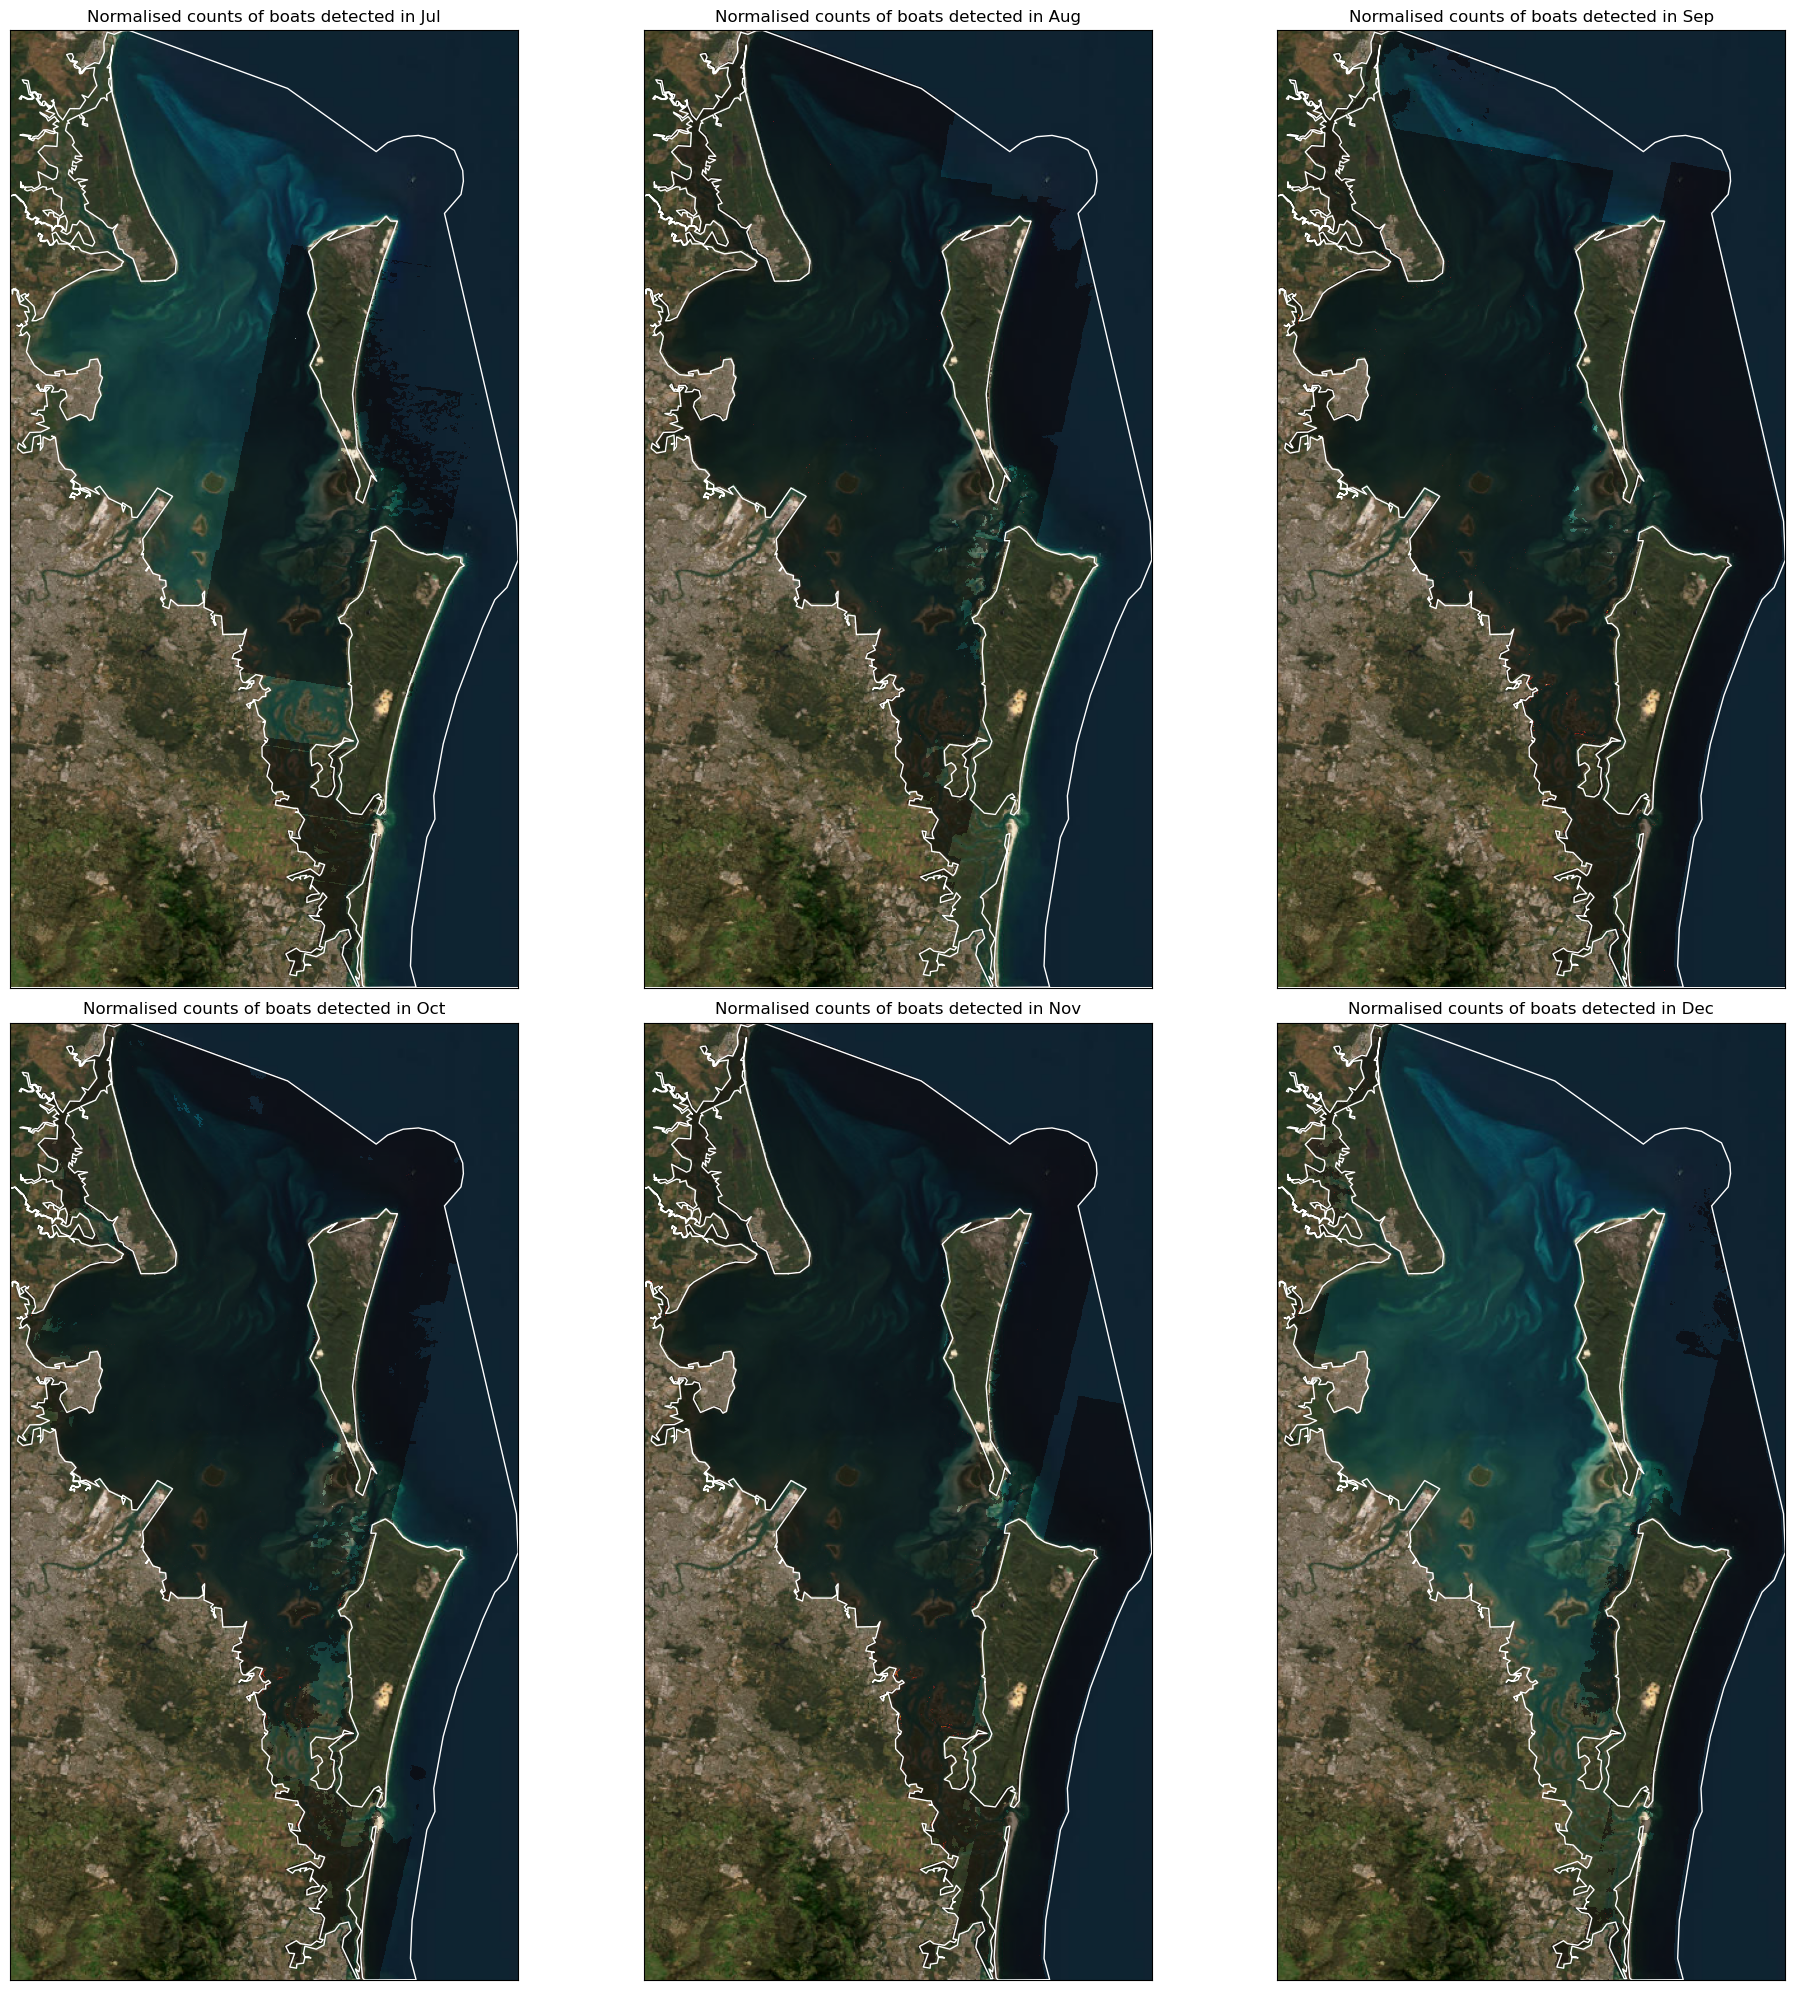

http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=153.01015278393564,-27.93324883315528,153.61062063249398,-26.802223773769505&bboxSR=4326&imageSR=4326&size=400,753&dpi=96&format=png32&transparent=true&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=153.01015278393564,-27.93324883315528,153.61062063249398,-26.802223773769505&bboxSR=4326&imageSR=4326&size=400,753&dpi=96&format=png32&transparent=true&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=153.01015278393564,-27.93324883315528,153.61062063249398,-26.802223773769505&bboxSR=4326&imageSR=4326&size=400,753&dpi=96&format=png32&transparent=true&f=image
http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=153.01015278393564,-27.93324883315528,153.61062063249398,-26.802223773769505&bboxSR=4326&imageSR=4326&size=400,753&dpi=96&format=png32&transparent=true&f=image
http://s

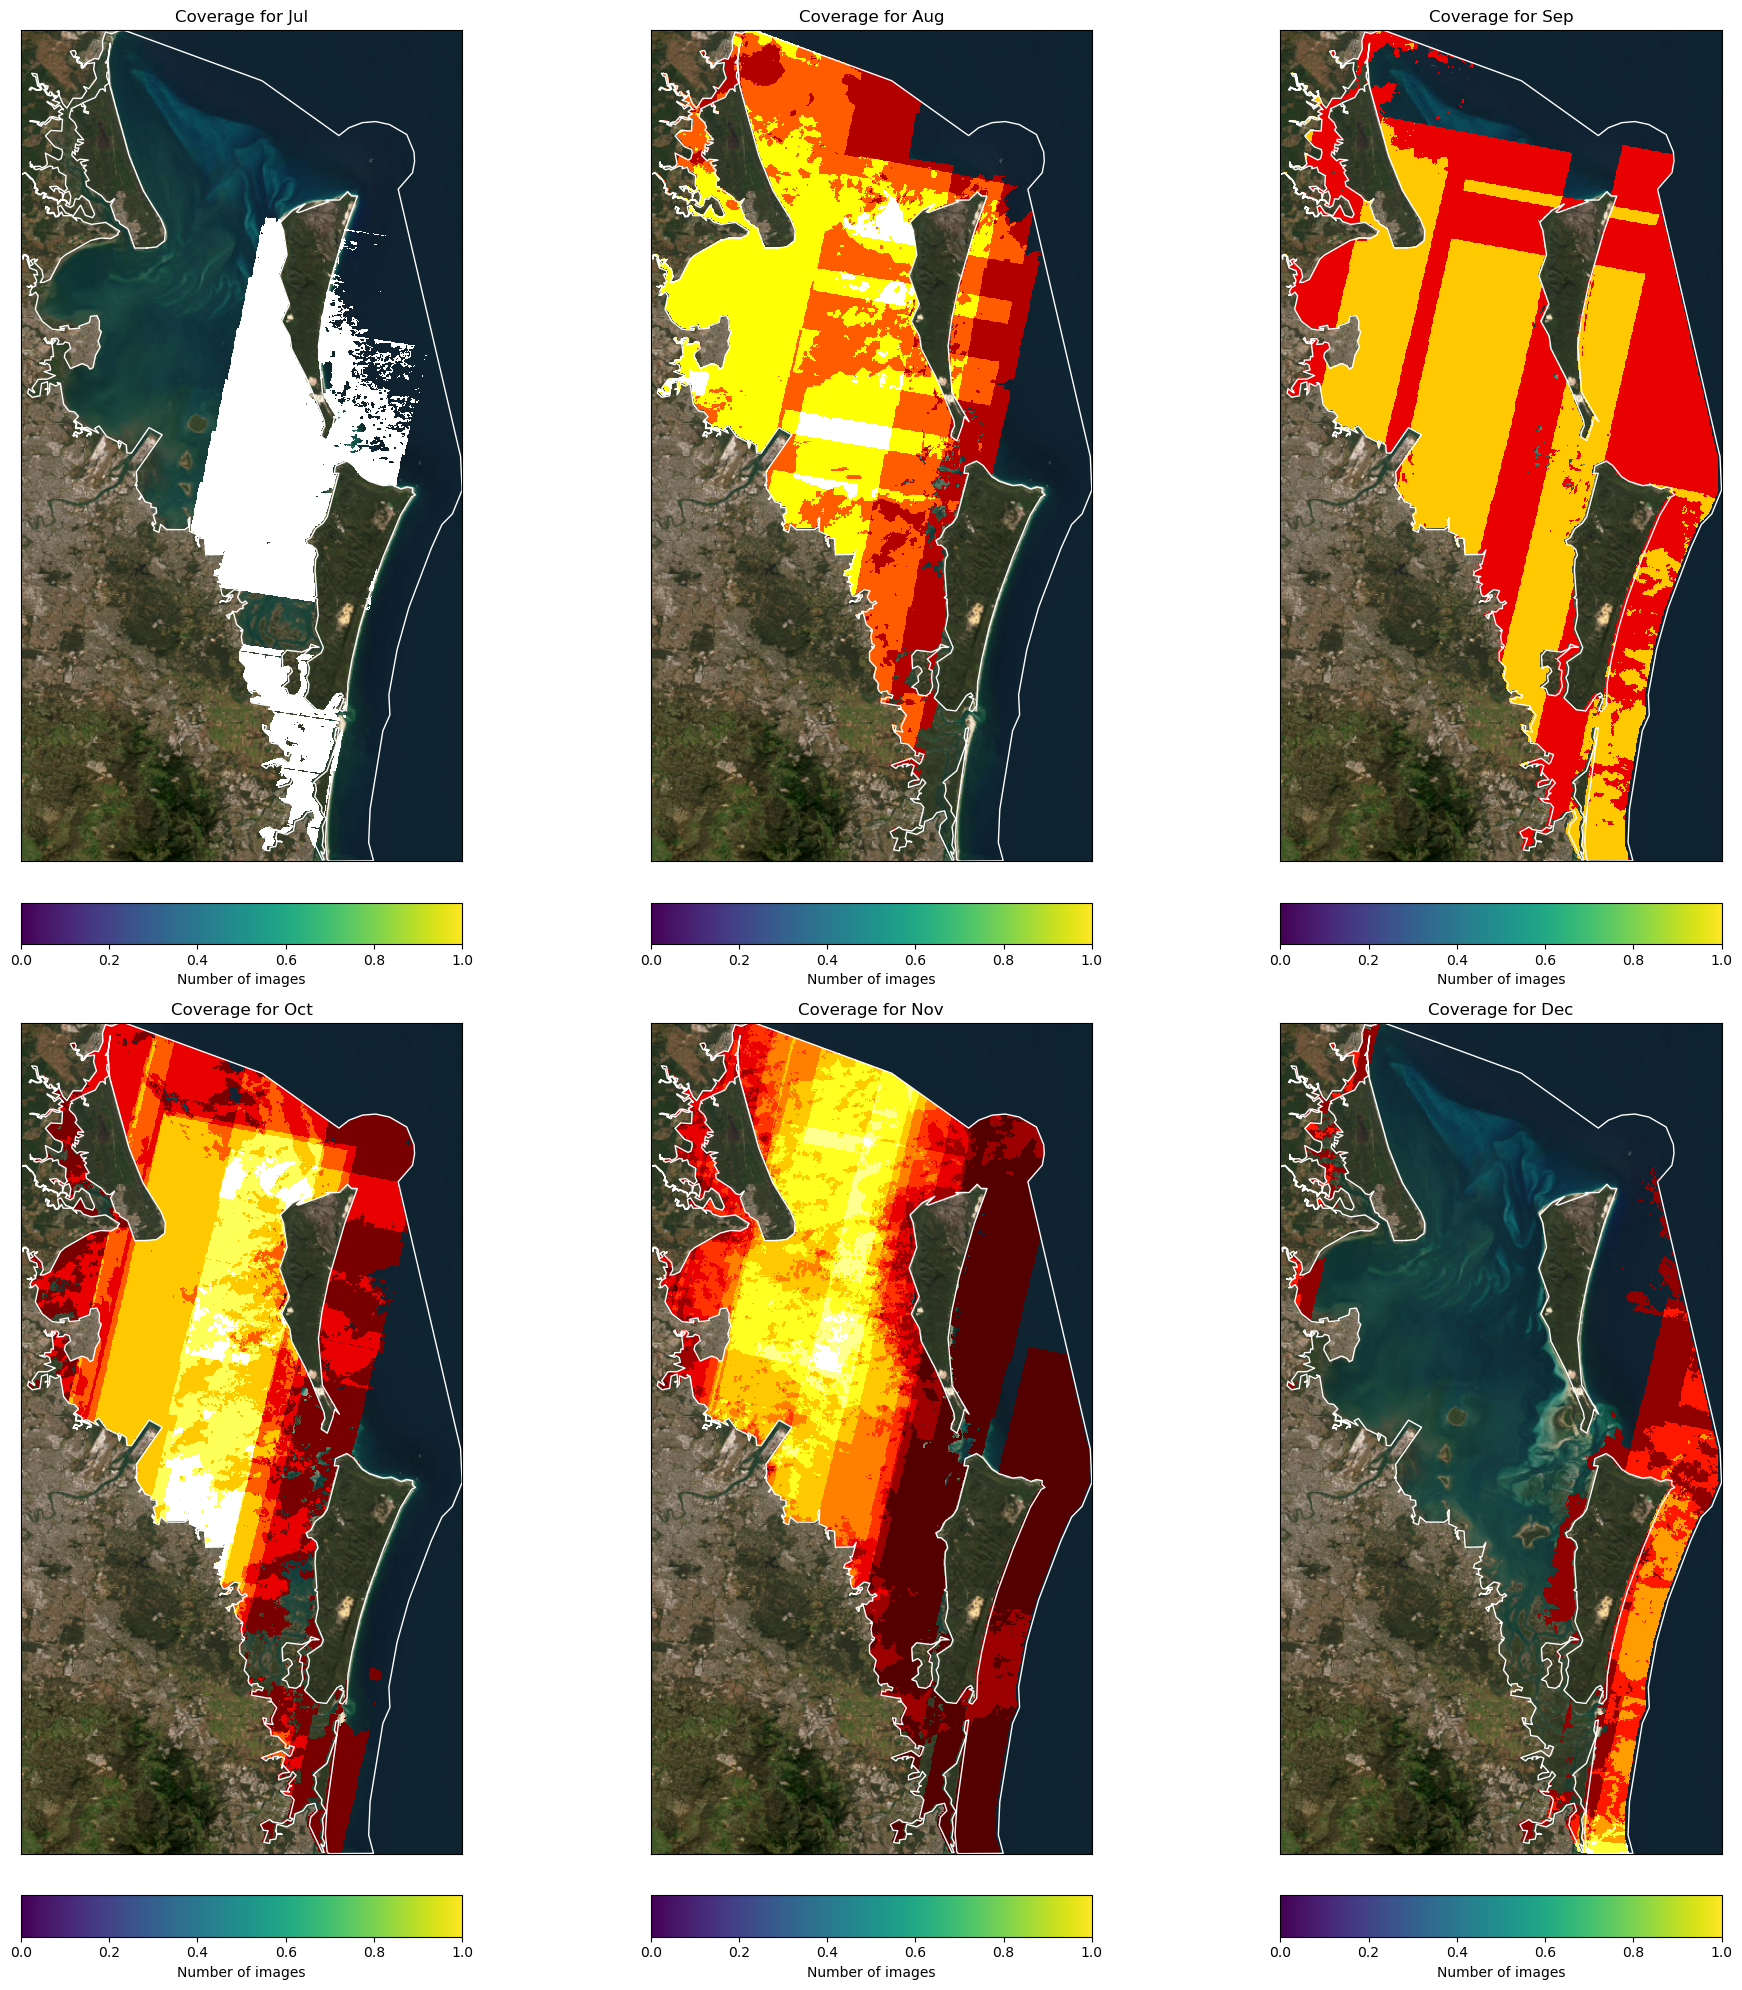

In [27]:
# same but for monthly data


month_to_month_name = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

date_to_month = lambda s: pd.to_datetime(f"{s[4:6]}/{s[6:8]}/{s[:4]}").month


all_detections['month'] = all_detections['date'].dt.month
all_detections['month'] = all_detections['month'].apply(lambda x: month_to_month_name[x])
month_grouped = all_detections.groupby('month')

heatmaps = generate_coverage_heatmaps(lambda fn: month_to_month_name[date_to_month(fn.split('_')[1])])

normalised_counts = normalise_counts(heatmaps, month_grouped)
plot_counts_on_map(normalised_counts, geojson_file)
plot_coverage(heatmaps)

In [28]:
# same but daily
all_detections['day'] = all_detections['date'].dt.day
day_grouped = all_detections.groupby('day')

dayofweek_to_dayname = lambda x: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][x]

date_to_dayofweek = lambda s: pd.to_datetime(f"{s[4:6]}/{s[6:8]}/{s[:4]}").day

heatmaps = generate_coverage_heatmaps(lambda fn: dayofweek_to_dayname(date_to_dayofweek(fn.split('_')[1])))

normalised_counts = normalise_counts(heatmaps, day_grouped)
plot_counts_on_map(normalised_counts, geojson_file)
plot_coverage(heatmaps)


IndexError: list index out of range